In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
sample_submission = pd.read_csv('/kaggle/input/home-credit-default-risk/sample_submission.csv')
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
prev_apps = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')

In [ ]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.shape, test.shape

In [ ]:
train['TARGET'].astype(int).plot.hist();

In [ ]:
mis_val = train.isnull().sum()
mis_val_percent = 100 * train.isnull().sum() / len(train)
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(
columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
'% of Total Values', ascending=True).round(1)

mis_val_table_ren_columns
        

In [ ]:
train.dtypes.value_counts()

In [ ]:
train.select_dtypes('object')

We can encode categorical variables with 2 distinct values via lablel encoding (1 and 0), while other will be encoded via OneHot (although some variables like NAME_EDUCATION_TYPE seem to be ordinal, we will still use OneHot). 

However, before doing this, we should merge to datasets to ensure that we encode all possible categories.

In [ ]:
target = train.pop('TARGET')
target.head()


In [ ]:
data = pd.concat([train, test], keys = ['train', 'test'])
data.head()

In [ ]:
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [ ]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        if len(list(data[col].unique())) <= 2:
            le.fit(data[col])
            data[col] = le.transform(data[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

Now let's create dummies for other categorical variables using pandas.get_dummies

In [ ]:
print(data.shape)
data = pd.get_dummies(data)
print(data.shape)

In [ ]:
train = data.loc['train',:]
print(train.shape)
test = data.loc['test',:]
print(test.shape)

In [ ]:
train['DAYS_EMPLOYED'].describe()

In [ ]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')

Let's change this strange 365243 value to NaN and create an additional dummy variable.

In [ ]:
train.loc[:,'DAYS_EMPLOYED_ANOM'] = ((train["DAYS_EMPLOYED"] == 365243).apply(int)).to_numpy()
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
sum(train['DAYS_EMPLOYED_ANOM'])

In [ ]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')

In [ ]:
test['DAYS_EMPLOYED_ANOM'] = (test["DAYS_EMPLOYED"] == 365243).apply(int)
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [ ]:
sum(test['DAYS_EMPLOYED_ANOM'])

Now let's deal with missing data + perform normalizing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

train_copy = train.copy()
features = list(train.columns)
test_copy = test.copy()

train.pop('SK_ID_CURR')
test.pop('SK_ID_CURR')
# Impute missing values with median, since we use Logistic regression
imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')

# Let's use min-max scaling as well
scaler = MinMaxScaler(feature_range = (0, 1))


imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [ ]:
train_copy.head()

Now we can create our first prediction, based purely on factors included in train/test datasets.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(train)

from sklearn.metrics import roc_auc_score

print(kf)
model = LogisticRegression(penalty = 'l1', solver = 'saga')
roc_auc_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train[train_index,:], train[test_index,:]
    y_train, y_test = target[train_index], target[test_index]

    model.fit(X_train, y_train)
    #print("model.coef_: ", model.coef_)
    predict = model.predict_proba(X_test)[:, 1]
    roc_auc = np.sqrt(roc_auc_score(y_test, predict))
    roc_auc_list.append(roc_auc)
    print(i, roc_auc)
    
print("Mean Roc-Auc for 10-fold: {}".format(str(np.mean(roc_auc_list))))
print("Std Roc-Auc for 10-fold: {}".format(str(np.std(roc_auc_list))))

In [ ]:
model = LogisticRegression(penalty = 'l1', solver = 'saga')
model.fit(train, target)

In [ ]:
log_reg_pred = model.predict_proba(test)[:, 1]


In [ ]:
submit = test_copy[['SK_ID_CURR']]
submit.loc[:,'TARGET'] = log_reg_pred


In [ ]:
submit

In [ ]:
submit.to_csv('logistic_baseline.csv', index = False)

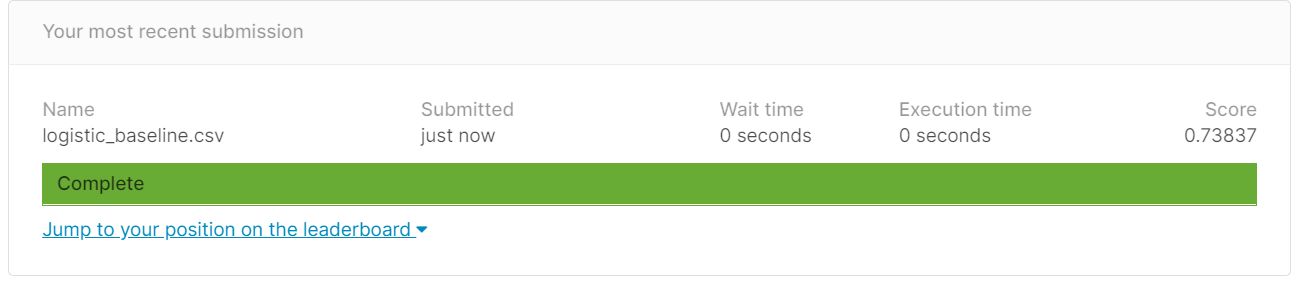